12.2.24

Þessi notebook er hugsuð til að vera safn af kóða fyrir ERA5 side quest.

In [1]:
# import cdsapi
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cfgrib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
import pandas as pd
import os
import folium
import geopandas as gpd
from shapely.geometry import Point
from pykrige.ok import OrdinaryKriging

import pykrige.kriging_tools as kt
from pykrige.uk import UniversalKriging

from scipy.interpolate import RegularGridInterpolator
import cdsapi

In [2]:
workspace_directory = r'C:\Users\trygg\Documents\Master_project' #HOME
# workspace_directory = r'C:\Users\tryggvisi\Documents\my-awesome-masters-project' #WORK
os.chdir(workspace_directory)  # Change the current working directory to the specified workspace

## Download request for ERA5

In [91]:
c = cdsapi.Client()
c.retrieve(
    'reanalysis-era5-land',
    {
        "area": [
            66.5,
            14.5,
            65.6,
            17,
        ],
        'variable': [
            'leaf_area_index_high_vegetation', 'leaf_area_index_low_vegetation', 'skin_temperature',
            'snow_density', 'snow_depth', 'snow_depth_water_equivalent',
            'temperature_of_snow_layer', 
            # 'total_precipitation',
        ],
        'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31'],
        'time': ['02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15'],
        "month": ["01", "02", "03", "04", "05"],
        "year": ["2017", "2018", "2019", "2020", "2021", "2022",
                 "2023"],
        'format': 'netcdf',
    },
    'download.nc')

2024-05-31 15:12:53,374 INFO Welcome to the CDS
2024-05-31 15:12:53,375 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2024-05-31 15:12:53,613 INFO Request is queued


KeyboardInterrupt: 

In [50]:
listi = []
for i in range(1,32):
    listi.append(str(i).zfill(2))
    # print(f'\'{i}\'')
    
print(listi)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']


## GRIB

In [ ]:
# Imprt the ERA5 GRIB data
# path_to_grib = r"Data\ERA5\ERA5_new_project\abcdefg.grib"
# path_to_grib = r"Data\ERA5\ERA5_new_project\adaptor.mars.internal-1710430612.139692-24364-13-4f6d1416-ff10-437a-89fa-9e1792914190.grib"
# path_to_grib = r"Data\ERA5\ERA5_new_project\adaptor.mars.internal-1710522257.4748845-8706-15-09626408-a9cb-4421-9d05-774452c086ec.grib" #nýjasta, allir data, milli 3-15, jan til apr, 2017-2023, minna svæði
# path_to_grib= r"Data\ERA5\ERA5_new_project\adaptor.mars.internal-1711410492.6102204-21099-3-77da3d55-77e6-498e-bbe1-eba5adc729cc.grib"#23.03  allir data, milli 3-15, jan til apr, 2017-2023, minna svæði, fleiri breytur
# path_to_grib = r"Data\ERA5\ERA5_more_granules\adaptor.mars.internal-1711620202.5725935-31333-8-83887a30-831d-43f8-92bd-63d8fb17e60f.grib" # snow depthtesta fyrir veðurfræðilegum breytingum. lítill

path_to_grib = r"Data\ERA5\ERA5_new_project\adaptor.mars.internal-1712742886.121778-17217-2-8e8a268a-2f00-4ee4-85c2-141d303d9a02.grib" # everything, 2017-2023, jan-apr, 3-15, 00-23
grib_file_path = path_to_grib

ds = xr.load_dataset(grib_file_path, engine="cfgrib")
era5_time = list(ds.time.values)

In [19]:
for v in ds:
    print("{}, {}, {}".format(v, ds[v].attrs["long_name"], ds[v].attrs["units"]))

rsn, Snow density, kg m**-3
sde, Snow depth, m
sd, Snow depth, m of water equivalent


# ERA5 -Land



In [39]:
def what_is_in_ds(ds):
    for v in ds:
        print("{}, {}, {}".format(v, ds[v].attrs["long_name"], ds[v].attrs["units"]))

In [51]:
# netcdf_file_path = r"C:\Users\trygg\Documents\Master_project\Data\ERA5_land\adaptor.mars.internal-1715766930.6635869-31765-6-a200f460-334d-4af3-99a7-32b83d4debbe.nc" #bara snow depth

netcdf_file_path = r"C:\Users\trygg\Documents\Master_project\Data\ERA5_land\adaptor.mars.internal-1715687018.5196297-2796-7-bccc8a41-f2ec-4a0b-806c-a6ce5f2094fc.nc" #era5land
ds = xr.open_dataset(netcdf_file_path)
era5_time = list(ds.time.values)
what_is_in_ds(ds)

rsn, Snow density, kg m**-3
sde, Snow depth, m
sd, Snow depth, m of water equivalent


In [40]:
netcdf_file_path = r"C:\Users\trygg\Documents\Master_project\Data\ERA5_land\adaptor.mars.internal-1716642815.810192-19982-4-8c6b0653-2dd0-4764-a338-f7c31e79328b.nc" #era5land
ds = xr.open_dataset(netcdf_file_path)
era5_time = list(ds.time.values)
what_is_in_ds(ds)

lai_hv, Leaf area index, high vegetation, m**2 m**-2
lai_lv, Leaf area index, low vegetation, m**2 m**-2
skt, Skin temperature, K
rsn, Snow density, kg m**-3
sde, Snow depth, m
sd, Snow depth, m of water equivalent
tsn, Temperature of snow layer, K
tp, Total precipitation, m


In [6]:
#temperature, skinskt, Skin temperature, K
#skt, Skin temperature, K
netcdf_file_path = r"C:\Users\trygg\Documents\Master_project\Data\ERA5_land\adaptor.mars.internal-1715696417.7502532-29298-8-26517478-0dc3-4ccd-9076-d779e94b04ca.nc" #era5land
ds_temp = xr.open_dataset(netcdf_file_path)
era5_time = list(ds.time.values)
what_is_in_ds(ds_temp)

skt, Skin temperature, K


In [7]:
netcdf_file_path = r"C:\Users\trygg\Documents\Master_project\Data\ERA5_land\adaptor.mars.internal-1716489653.9664931-5392-5-8eaa42ea-8e61-4971-b15a-21281714b55a.nc"
ds_tp = xr.open_dataset(netcdf_file_path)
ds_tp
what_is_in_ds(ds_tp)
ds_tp

tp, Total precipitation, m


<xarray.Dataset> Size: 2MB
Dimensions:    (longitude: 26, latitude: 21, time: 1058)
Coordinates:
  * longitude  (longitude) float32 104B 14.5 14.6 14.7 14.8 ... 16.8 16.9 17.0
  * latitude   (latitude) float32 84B 67.0 66.9 66.8 66.7 ... 65.2 65.1 65.0
  * time       (time) datetime64[ns] 8kB 2017-01-01T12:00:00 ... 2023-05-31T1...
Data variables:
    tp         (time, latitude, longitude) float32 2MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-23 18:40:56 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [ ]:
#merge two ds together
ds_merger = xr.merge([ds_temp, ds_snow])
ds_merger = ds_merger.drop_vars("sd")
what_is_in_ds(ds_merger)
ds = ds_merger

# Vindelfjallen data prep

In [41]:
#Load vindelfjallen data
csv_file_path_2023 = r"Data\Vindefjallen_data\Vindefjallen_cleaning\Vindefjallen_Granule_processing\vindefjallen_corner_coords_processing_2023_middletime.csv"

df_measurements = pd.read_csv(csv_file_path_2023) # Read the CSV file into a DataFrame
vindefjallen_triangleCorners_numpy_2023 = df_measurements.to_numpy()# Convert the DataFrame to a NumPy array for easier coding

df_measurements = df_measurements.dropna(subset=['MiddleTime'])
df_measurements = df_measurements.reset_index(drop=True)

len(df_measurements)

498

In [ ]:
# Not necessary to run this cell
########### stuff for data frames

column_name = 'date'

df_time[column_name].unique()

test = df_time.copy()
# df_measurements['date'].unique() sort the dates
test[column_name] = pd.to_datetime(df_time[column_name])
test = df_time.sort_values(by=[column_name])
len(test[column_name].unique())
#count how many measurements are in each date
print(test[column_name].value_counts().to_markdown())


# # Iterate over each data variable
# for var_name in ds_special.data_vars:
#     # Extract the values of the variable
#     var_values = ds_special.data_vars[var_name].values
    
#     # Now you can work with the values as needed
#     # For example, print the values
#     print(f"Values of {var_name}: {var_values}" )

In [ ]:
def unq_list(listi):
    output = []
    for x in listi:
        if x not in output:
            output.append(x)
    # print(output)
    return sorted(output)
date = df_time['date'].unique()
years = []
months = []
days = []
for i in date:
    splt = i.split('-')
    yr, mn, dy = splt
    years.append(yr)
    months.append(mn)
    days.append(dy)
    
    
middletime = df_time['MiddleTime'].unique()
hours = []
for i in middletime:
    time = i.split(':')[0]
    print(time)
    hours.append(time)
    
#unique list
years_unq = unq_list(years)
months_unq = unq_list(months)
days_unq = unq_list(days)
hours_unq = unq_list(hours)

print(years_unq)
print(months_unq)
print(days_unq)
print(hours_unq)

In [42]:
# Plan: Create a new dataframe that contains all the dates and times present in the ERA5 data
#remove nan from MiddleTime

# Convert the MiddleTime column to hours and minutes in seconds
df_time = df_measurements.copy()
hours = pd.to_datetime(df_time["MiddleTime"], format="%H:%M:%S").dt.hour * 3600
minutes = pd.to_datetime(df_time["MiddleTime"], format="%H:%M:%S").dt.minute * 60
total_seconds = (hours + minutes) / 3600
total_seconds = total_seconds.astype(int)
df_time = df_time.assign(time_difference_rnd=total_seconds)

print(df_time.shape)
# Iterate over the df_time and add leading zero to the time_difference_rnd_bins
for i in range(len(df_time)):
    if df_time.loc[i, "time_difference_rnd"] < 10:
        # temp1 = df_time.loc[i, 'date'] + 'T' + '0' + str(df_time.loc[i, "time_difference_rnd"]) #með tíma sem er dags + round sem er nákvæmlega þegar mælingin var gerð
        temp1 = df_time.loc[i, 'date'] + 'T' + '13' # nýtt era-5 land sem er bara kliukkan 13
        df_time.loc[i, "ERA5_time"] = temp1
    else:
        # temp2 = df_time.loc[i, 'date'] + 'T' + str(df_time.loc[i, "time_difference_rnd"])#með tíma sem er dags + round sem er nákvæmlega þegar mælingin var gerð
        temp2 = df_time.loc[i, 'date'] + 'T' + '13' ## nýtt era-5 land sem er bara kliukkan 13
        df_time.loc[i, "ERA5_time"] = temp2

# Find all matches between the time in the measurements and the time in the ERA5 data
#It creates a new column with 1 if the time exists in the ERA5 data, otherwise 0
teljari = 0
# for i in range(len(df_time['ERA5_time'])):
#     for j in range(len(era5_time)):
#         if df_time.loc[i, 'ERA5_time'] in str(era5_time[j]):
#             teljari += 1
#             df_time.loc[i, 'ERA5_time_exists'] = 1


# df_time = df_time[~df_time["SnowDepth"].str.contains(r"\d+\+")]
# df_time["SnowDepth"] = df_time["SnowDepth"].astype(np.int64)
df_time.shape


(498, 15)


(498, 16)

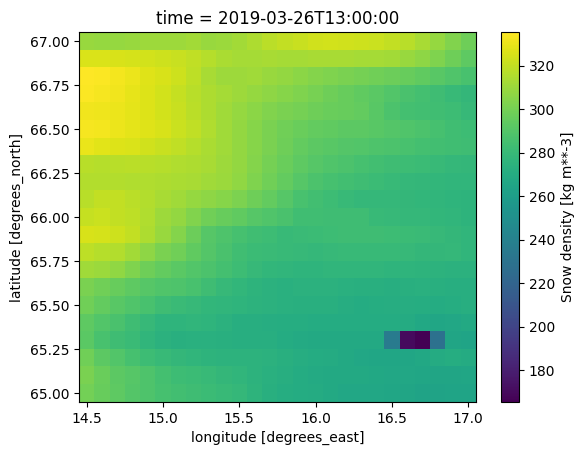

In [45]:
ds.sel(time='2019-03-26T13').rsn.plot()

### Create a dataset for exporting to RF model

In [46]:
#loop through df_time and get the values of all the era5 parameters for each time and location and add it to the dataframe
#create a for loop for df_time and display the values of the era5 data
df_working = df_time.copy()
for i in range(len(df_working)):
    #get the time
    tíminn_er_minn = df_working['ERA5_time'].iloc[i]
    # tíminn_er_minn = pd.to_datetime(tíminn_er_minn)
    #get the latitude
    latitude_y = df_working['y_4326'].iloc[i]
    #get the longitude
    longitude_x = df_working['x_4326'].iloc[i]
    #select the data from the era5 data
    # print(tíminn_er_minn	, type(tíminn_er_minn))
    ds_special = ds.sel(time=tíminn_er_minn, latitude=latitude_y, longitude=longitude_x, method='nearest')
    #iterate over the data variables
    for var_name in ds_special.data_vars:
        # Extract the values of the variable
        var_values = ds_special.data_vars[var_name].values
        #add values to the dataframe
        df_working.loc[i, var_name] = var_values

df_working_temp = df_working.drop(
    [
        "OG_ID",
        "temperature",
        "time_difference_rnd",
        # "ERA5_time_exists",
        "x_4326",
        "y_4326",
        "x_3006",
        "y_3006",
        "SnowDepth",
        "SnowDepth_Noplus",
        "MiddleTime",
        "Triangle",
        "Corner",
        "TriangleCorner",
        "date",
        
        # 'tp'
    
    ],
    axis=1,
)

In [ ]:

#change columns names rsn to era5_l_rsn etc
df_working_temp.columns = df_working_temp.columns.str.replace('skt', 'era5_l_skt')
df_working_temp.columns = df_working_temp.columns.str.replace('rsn', 'era5_l_rsn')
df_working_temp.columns = df_working_temp.columns.str.replace('sd', 'era5_l_sd')
df_working_temp.columns = df_working_temp.columns.str.replace('lai_hv', 'era5_l_lai_hv')
df_working_temp.columns = df_working_temp.columns.str.replace('lai_lv', 'era5_l_lai_lv')
df_working_temp.columns = df_working_temp.columns.str.replace('tsn', 'era5_l_tsn')
print(df_working_temp.to_markdown())

In [103]:
#export df_working_temp to csv
path = r"Scripts\Python\ERA5\era5_temp\era5_land_vindefjallen_data_2023_7params.csv"
df_working_temp.to_csv(path, index=False)

# ERA5 stuff

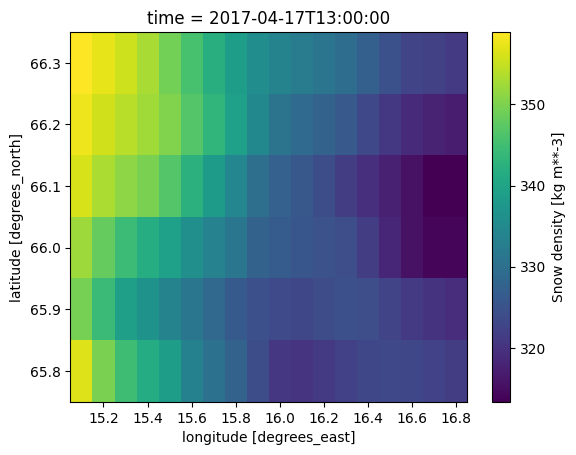

In [48]:
#study area bounds
lat_max, lat_min = 65.75, 66.3  # Example latitude bounds
lon_min, lon_max = 15.1, 16.85  # Example longitude bounds
clipped_ds = ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))

time = df_time['ERA5_time'].to_list() # Get the ERA5 time values from the DataFrame
time.sort()

# ds.isel(time='2018-03-28')
clipped_ds.rsn[100].plot(cmap=plt.cm.viridis)

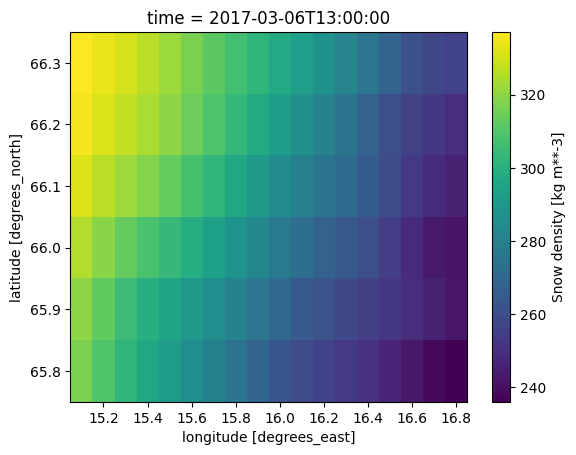

In [50]:
clipped_ds.rsn.sel(time='2017-03-06').plot(cmap=plt.cm.viridis)

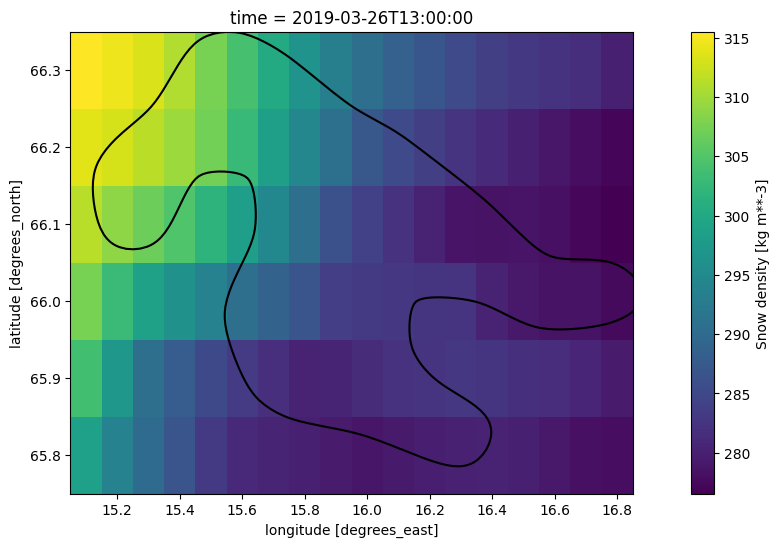

In [51]:
#Visual
#Plot era5 and study area
study_area = gpd.read_file(r"Data\Vindefjallen_data\outputs\shapefiles\study_area_4326.shp")
fig, ax = plt.subplots(1,1, figsize=(15, 6))

clipped_ds.rsn.sel(time='2019-03-26').plot(cmap=plt.cm.viridis)
study_area.boundary.plot(ax=ax, color='black')
plt.show()  # This line will display the plot

In [ ]:
'''
actual_snow_depth_in_m = RW*SD/RSN

where:

SD= snow depth in m of water equivalent (parameter 141.128)

RW, density of water, = 1000 kg/m3

RSN = density of snow in kg/m3 (parameter 33.128)
'''
#https://forum.ecmwf.int/t/how-to-convert-snowfall-m-of-water-equivalent-to-m/1155
#

#snow depth conversion function
def snow_depth_conversion(ds):


    SD = ds.sd
    RW = 1000
    RSN = ds.rsn
    real_SD = RW*(SD/RSN) * 100 # based on forum post
    
    # real_SD = ds.sd/ds.rsn*1000*100
    # real_SD = ds.rsn * ds.sd
    return real_SD 

ds_visual_big = snow_depth_conversion(ds)
# ds_visual_big.isel(time=90).plot(cmap=plt.cm.coolwarm)
plt.show()
ds_visual_small = snow_depth_conversion(clipped_ds)
ds_visual_small.isel(time=90).plot(cmap=plt.cm.coolwarm);
# ds_snow_depth.plot(cmap=plt.cm.coolwarm)

In [88]:
#Export to tif
date = '2019-03-15'
sde = clipped_ds.sde.sel(time=date)
sde = sde * 100
sde.rio.set_crs("EPSG:4326", inplace=True)
path_to_era = r'C:\Users\trygg\Documents\Master_project\Data\Prediction_SD\ERA5\sde_' + date + '.tif'
sde.rio.to_raster(path_to_era)

sd = clipped_ds.sd.sel(time=date)
sd = sd * 100
sd.rio.set_crs("EPSG:4326", inplace=True)
path_to_era = r'C:\Users\trygg\Documents\Master_project\Data\Prediction_SD\ERA5\sd_' + date + '.tif'
sd.rio.to_raster(path_to_era)

skt = clipped_ds.skt.sel(time=date)
skt = skt -273.15
skt.rio.set_crs("EPSG:4326", inplace=True)
path_to_era = r'C:\Users\trygg\Documents\Master_project\Data\Prediction_SD\ERA5\skt_' + date + '.tif'
skt.rio.to_raster(path_to_era)

rsn = clipped_ds.rsn.sel(time=date)

# rsn.rio.set_crs("EPSG:4326", inplace=True)
# path_to_era = r'C:\Users\trygg\Documents\Master_project\Data\Prediction_SD\ERA5\rsn_20190326.tif'
# rsn.rio.to_raster(path_to_era)

data_array = clipped_ds['rsn'].sel(time=date)
data_array = data_array.clip(min=180, max=350)
# Ensure the data array has spatial coordinates and define the CRS
data_array = data_array.rio.write_crs("EPSG:4326")

# Define the output file path
output_tif = r'C:\Users\trygg\Documents\Master_project\Data\Prediction_SD\ERA5\rsn_' + date + '.tif'

# Export the DataArray to GeoTIFF
data_array.rio.to_raster(output_tif)

: 

In [83]:
rsn = clipped_ds.rsn.sel(time='2022-03-27T13')
rsn.clip(min=180, max=350)
rsn.rio.set_crs("EPSG:4326", inplace=True)
path_to_era = r'C:\Users\trygg\Documents\Master_project\Data\Prediction_SD\ERA5\rsn_20190326.tif'
rsn.rio.to_raster(path_to_era)

In [ ]:
import xarray as xr
import rioxarray

# Load your dataset (replace with your dataset path)
ds = xr.open_dataset('path/to/your/dataset.nc')

# Select the data variable you want to export
data_array = ds['rsn']
data_array = data_array.clip(min=180, max=350)
# Ensure the data array has spatial coordinates and define the CRS
data_array = data_array.rio.write_crs("EPSG:4326")

# Define the output file path
output_tif = 'path/to/output2.tif'

# Export the DataArray to GeoTIFF
data_array.rio.to_raster(output_tif)

print(f"Data has been exported to {output_tif}")


# interpolaton

## Interpolation with increased number of era5 points 

In [45]:
# #code to create a dataset with points in center, and bottom and top, i.e. 3 points per pixel
# # NOT WORK!!
# chosen_time = '2022-01-29'
# chosen_time_era = chosen_time + 'T' + '12'
# df_time_filtered = df_time.loc[df_time['ERA5_time'] == chosen_time_era]

# def create_dataset(ds_snow_depth, lat_shift=0, lon_shift=0):
#     # Generate datasets for different center adjustments
    

#     data = ds_snow_depth.values
#     lat_centers = lats + lat_shift
#     lon_centers = lons + lon_shift
#     grid = np.zeros((len(lats), len(lon_centers)))
#     grid[:, :] = data[:len(lat_centers), :len(lon_centers)]
#     data_array = xr.DataArray(grid,
#                                dims=('latitude', 'longitude'),
#                                coords={'latitude': lat_centers,
#                                        'longitude': lon_centers})
#     return xr.Dataset({'snow_depth': data_array})



# # Convert into real snow depth
# # ds_snow_depth = snow_depth_conversion(clipped_ds)
# ds_snow_depth = ds
# ds_snow_depth = ds_snow_depth.sel(time=chosen_time_era)

# lats = ds_snow_depth['latitude'].values
# lons = ds_snow_depth['longitude'].values
# shifts = [(0, 0), ((lats.max() - lats.min())/4, 0), (-(lats.max() - lats.min())/4, 0)]
# ds_center_datasets = []
# for lat_shift, lon_shift in shifts:
#     ds_center = create_dataset(ds_snow_depth, lat_shift, lon_shift)
#     ds_center_datasets.append(ds_center)

# ds_center_plain, ds_center_plus, ds_center_minus  = ds_center_datasets

# ds_center = xr.merge([ds_center_plain, ds_center_plus, ds_center_minus])
# # Now, merged_ds contains the merged dataset
# # ds_snow_depth.plot(cmap=plt.cm.coolwarm)

# # ds_center.plot.scatter(x='longitude', y='latitude', hue='snow_depth', cmap='coolwarm')

In [92]:
#Create points at the center of each pixel
ds_snow_depth = clipped_ds.sde.isel(time=0)
# Get latitude and longitude values from ds_skin1
lats = ds_snow_depth['latitude'].values
lons = ds_snow_depth['longitude'].values

chosen_time = '2017-02-21'
chosen_time_era = chosen_time + 'T' + '13'
df_time_filtered = df_time.loc[df_time['ERA5_time'] == chosen_time_era]
# Get data values from ds_skin1
data = ds_snow_depth.values  # Replace 'your_variable_name' with the variable you want to extract

# Calculate latitude and longitude centers
lat_centers = ((lats + lats) / 2)
lon_centers = ((lons + lons) / 2)

# Create a grid with zeros
grid = np.zeros((len(lat_centers), len(lon_centers)))
grid[:, :] = data[:len(lat_centers), :len(lon_centers)]  # Ensure data matches the shape of the grid

# Create a DataArray with the grid data
data_array = xr.DataArray(grid, 
                          dims=('latitude', 'longitude'),
                          coords={'latitude': lat_centers,
                                  'longitude': lon_centers})

# Create a Dataset containing the DataArray
ds_center = xr.Dataset({'snow_depth': data_array})

# Optionally, you can assign coordinate variables if needed
ds_center['latitude'] = lat_centers
ds_center['longitude'] = lon_centers

In [93]:
#### Creat the first shapefile with the base data
path_shp = r"Scripts\Python\ERA5\era5_shp"

name_base = r"base_shapefile_time.shp"

complete_path_base = os.path.join(path_shp, name_base)

# Load your xarray dataset
dataset = ds_center
# Extract coordinates and data variable
longitude = dataset.longitude.values.flatten()  # Reshape to 1D
latitude = dataset.latitude.values.flatten()  # Reshape to 1D
skt_values = dataset.snow_depth.values.flatten()  # Reshape to 1D

if len(longitude) * len(latitude) == len(skt_values):
    # Create meshgrid for coordinates
    lon_mesh, lat_mesh = np.meshgrid(longitude, latitude)
    # Reshape longitude, latitude to match skt_values
    longitude = lon_mesh.flatten()
    latitude = lat_mesh.flatten()
    # Create a GeoDataFrame
    geometry = gpd.points_from_xy(longitude, latitude)
    gdf = gpd.GeoDataFrame({'snow_depth': skt_values}, geometry=geometry)
    # Write GeoDataFrame to shapefile
    gdf.to_file(complete_path_base)
    print("Shapefile successfully created.", complete_path_base)
else:
    print("Error: Lengths of longitude, latitude, and skt_values arrays do not match")
    
########_------------------------------------------------------------------

#Create the second shapefile with the base data and the plus points
df_select_time = df_time.loc[df_time['date'] == chosen_time]
# Define the name of the output shapefile
name_output_pluspoints = r"output_shapefile_time_pluspoints.shp"

# Create the complete path of the output shapefile
complete_path_output_pluspoints = os.path.join(path_shp, name_output_pluspoints)

# Read the base shapefile into a GeoDataFrame
combined_gdf = gpd.read_file(complete_path_base)

# Iterate over the rows of the df_select_time DataFrame
for index, row in df_select_time.iterrows():
    lon = row['x_4326']
    lat = row['y_4326']
    skt_value = float(row['SnowDepth_Noplus'])
    # print(lon, lat, skt_value, row['date'])
    
    # Create a new Point object
    new_point = Point(lon, lat)
    
    # Create a new GeoDataFrame with the snow depth value and the geometry of the new point
    new_gdf = gpd.GeoDataFrame({'snow_depth': [skt_value]}, geometry=[new_point])
    
    # Concatenate the new GeoDataFrame with the combined GeoDataFrame
    combined_gdf = gpd.GeoDataFrame(pd.concat([combined_gdf, new_gdf], ignore_index=True))
    
    # Save the combined GeoDataFrame to the output shapefile
    combined_gdf.to_file(complete_path_output_pluspoints)

Shapefile successfully created. Scripts\Python\ERA5\era5_shp\base_shapefile_time.shp


## Interpolation with only center points


In [94]:
def create_shp_and_more(chosen_time):  

    chosen_time_era =chosen_time + 'T' + '13'
    df_time.loc[df_time['ERA5_time'] == chosen_time_era]

    #convert into real snow depth
    ds_snow_depth = clipped_ds.sde * 100
    ds_snow_depth = ds_snow_depth.sel(time=chosen_time_era)

    #Create a grid with a point at the center of each of the pixel cell and retain the cell value
    # Get latitude and longitude values from ds_snow_depth
    lats = ds_snow_depth['latitude'].values
    lons = ds_snow_depth['longitude'].values

    # Get data values from ds_snow_depth
    data = ds_snow_depth.values  # Replace 'your_variable_name' with the variable you want to extract

    # Calculate latitude and longitude centers
    lat_centers = ((lats + lats) / 2)
    lon_centers = ((lons + lons) / 2)

    # Create a grid with zeros
    grid = np.zeros((len(lat_centers), len(lon_centers)))
    grid[:, :] = data[:len(lat_centers), :len(lon_centers)]  # Ensure data matches the shape of the grid

    # Create a DataArray with the grid data
    data_array = xr.DataArray(grid, 
                            dims=('latitude', 'longitude'),
                            coords={'latitude': lat_centers,
                                    'longitude': lon_centers})

    # Create a Dataset containing the DataArray
    ds_center = xr.Dataset({'snow_depth': data_array})

    # Optionally, you can assign coordinate variables if needed
    ds_center['latitude'] = lat_centers
    ds_center['longitude'] = lon_centers

    # # Plotting ds_snow_depth as the background
    # ds_snow_depth.plot(cmap=plt.cm.coolwarm)

    # # Plotting dataset on top of ds_snow_depth
    # ds_center.plot.scatter(x='longitude', y='latitude', hue='snow_depth', cmap='coolwarm')
    # plt.title(ds_snow_depth.time.values)
    # plt.show()

    #### Creat the first shapefile with the base data
    path_shp = r"Scripts\Python\ERA5\era5_shp"

    name_base = r"base_shapefile_time.shp"

    complete_path_base = os.path.join(path_shp, name_base)

    # Load your xarray dataset
    dataset = ds_center
    # Extract coordinates and data variable
    longitude = dataset.longitude.values.flatten()  # Reshape to 1D
    latitude = dataset.latitude.values.flatten()  # Reshape to 1D
    skt_values = dataset.snow_depth.values.flatten()  # Reshape to 1D

    if len(longitude) * len(latitude) == len(skt_values):
        # Create meshgrid for coordinates
        lon_mesh, lat_mesh = np.meshgrid(longitude, latitude)
        # Reshape longitude, latitude to match skt_values
        longitude = lon_mesh.flatten()
        latitude = lat_mesh.flatten()
        # Create a GeoDataFrame
        geometry = gpd.points_from_xy(longitude, latitude)
        gdf = gpd.GeoDataFrame({'snow_depth': skt_values}, geometry=geometry)
        # Write GeoDataFrame to shapefile
        gdf.to_file(complete_path_base)
        print("Shapefile successfully created.", complete_path_base)
    else:
        print("Error: Lengths of longitude, latitude, and skt_values arrays do not match")
        
    ########_------------------------------------------------------------------

    #Create the second shapefile with the base data and the plus points
    df_select_time = df_time.loc[df_time['date'] == chosen_time]
    # Define the name of the output shapefile
    name_output_pluspoints = r"output_shapefile_time_pluspoints.shp"

    # Create the complete path of the output shapefile
    complete_path_output_pluspoints = os.path.join(path_shp, name_output_pluspoints)

    # Read the base shapefile into a GeoDataFrame
    combined_gdf = gpd.read_file(complete_path_base)

    # Iterate over the rows of the df_select_time DataFrame
    for index, row in df_select_time.iterrows():
        lon = row['x_4326']
        lat = row['y_4326']
        skt_value = float(row['SnowDepth'])
        # print(lon, lat, skt_value, row['date'])
        
        # Create a new Point object
        new_point = Point(lon, lat)
        
        # Create a new GeoDataFrame with the snow depth value and the geometry of the new point
        new_gdf = gpd.GeoDataFrame({'snow_depth': [skt_value]}, geometry=[new_point])
        
        # Concatenate the new GeoDataFrame with the combined GeoDataFrame
        combined_gdf = gpd.GeoDataFrame(pd.concat([combined_gdf, new_gdf], ignore_index=True))
        
        # Save the combined GeoDataFrame to the output shapefile
        combined_gdf.to_file(complete_path_output_pluspoints)
    return ds_snow_depth

In [ ]:
#NOT MAIN CODE
#Plot era5 and study area
gdf_plus_points = gpd.read_file(complete_path_output_pluspoints)
#add the polygon from study_area_path to the plot
study_area_path = r"Data\Vindefjallen_data\outputs\shapefiles\study_area_4326.shp"
study_area = gpd.read_file(study_area_path)
fig, ax = plt.subplots(1,1, figsize=(15, 6))
ds_snow_depth.plot(cmap=plt.cm.viridis, ax=ax)
gdf_plus_points.plot(column='snow_depth', cmap='viridis', legend=True, s=100, ax=ax)


study_area.boundary.plot(ax=ax, color='black')
plt.show()  # This line will display the plot

## Call the function and provide some data

In [95]:
# chosen_time = '2018-03-28'
# chosen_time = '2017-04-16'
chosen_time = '2020-04-28'
ds_snow_depth = create_shp_and_more(chosen_time)
gdf_plus_points = gpd.read_file(complete_path_output_pluspoints)
xx = gdf_plus_points.geometry.x.values
yx = gdf_plus_points.geometry.y.values
zz = gdf_plus_points['snow_depth'].values  # Change 'value_column' to the column containing the values
listi_measurement = []
listi_era5 = []
for index, row in df_select_time.iterrows():
    skt_value = float(row['SnowDepth'])
    listi_measurement.append(skt_value)
for i in ds_snow_depth.values:
    # print(i)
    for k in i:
        listi_era5.append(k)
import statistics
print(chosen_time)
print('mean',round(zz.mean()))
print('std',round(zz.std()))  
print('max',round(zz.max()))
print('min',round(zz.min()))
print('mean era5',round(statistics.mean(listi_era5)))
print('mean meas',round(statistics.mean(listi_measurement)))
print('count:', len(listi_measurement))
print('quality?: ')
print('----------------------------------------')

Shapefile successfully created. Scripts\Python\ERA5\era5_shp\base_shapefile_time.shp
2020-04-28
mean 176
std 44
max 267
min 80
mean era5 178
mean meas 82
count: 3
quality?: 
----------------------------------------


## Kriging code and plotting

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


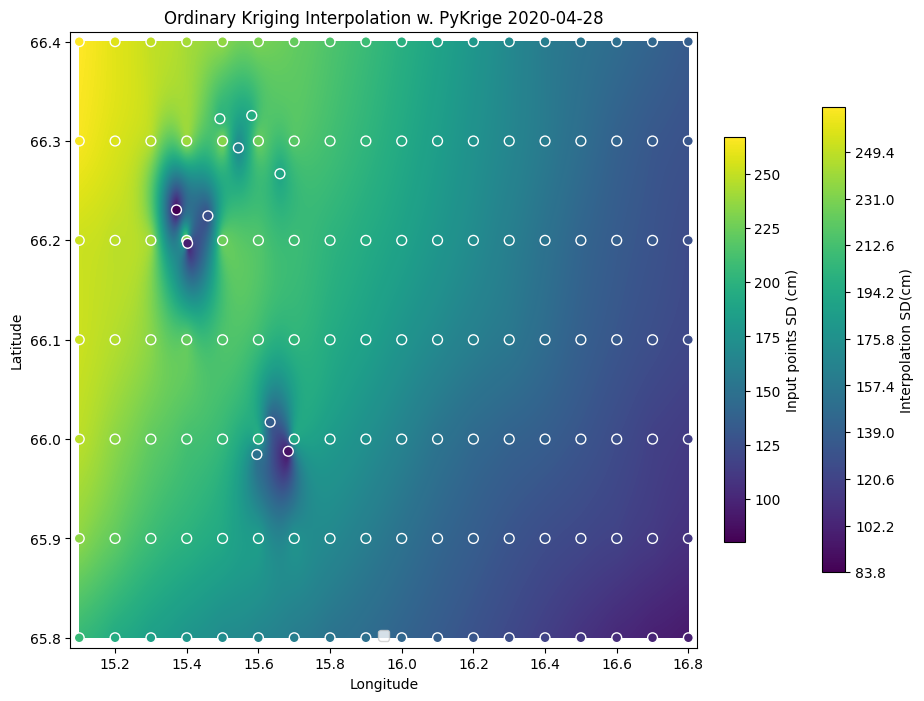

In [96]:
#Ordinary kriging
gdf_plus_points = gpd.read_file(complete_path_output_pluspoints)

# Extract coordinates and values
x = gdf_plus_points.geometry.x.values
y = gdf_plus_points.geometry.y.values
z = gdf_plus_points['snow_depth'].values  # Change 'value_column' to the column containing the values

gridx = np.linspace(min(x), max(x), 500)
gridy = np.linspace(min(y), max(y), 500)
# Create an OrdinaryKriging object
ok = OrdinaryKriging(x, y, z, variogram_model='linear', verbose=False)
grid_z, ss = ok.execute('grid', gridx, gridy)
fig, ax = plt.subplots(figsize=(10, 8))

contour = ax.contourf(gridx, gridy, grid_z, levels=1000, cmap='viridis', alpha=1)
scatter = ax.scatter(x, y, c=z, cmap='viridis',edgecolors='w')
# point size
scatter.set_sizes([50])


# Add colorbar
cbar = plt.colorbar(contour, ax=ax, fraction=0.03, pad=0.1)
cbar.set_label('Interpolation SD(cm)')
cbar = plt.colorbar(scatter, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label('Input points SD (cm)')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Ordinary Kriging Interpolation w. PyKrige {chosen_time}')
plt.xlim(min(x)-0.025, max(x)+0.025)
plt.ylim(min(y)-0.01, max(y)+0.01)
plt.legend()

plt.show()

In [97]:
#Universal kriging
gdf_plus_points = gpd.read_file(complete_path_output_pluspoints)

# Extract coordinates and values
x = gdf_plus_points.geometry.x.values
y = gdf_plus_points.geometry.y.values
z = gdf_plus_points['snow_depth'].values  # Change 'value_column' to the column containing the values


gridx = np.linspace(min(x), max(x), 500)
gridy = np.linspace(min(y), max(y), 500)
# Create an OrdinaryKriging object
ok = UniversalKriging(x, y, z, variogram_model='linear', verbose=False)
grid_z, ss = ok.execute('grid', gridx, gridy)
# Generate grid coordinates for visualization
# Plot the results


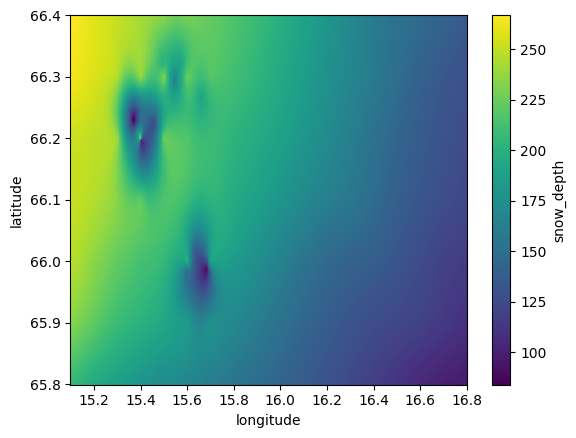

In [98]:
grid_z_data = grid_z.data

ds_test3 = xr.Dataset(
    {
        "snow_depth": (["latitude", "longitude"], grid_z_data),
        "longitude": (["longitude"], gridx),
        "latitude": (["latitude"], gridy),
    }
)
plotx = ds_test3.snow_depth.plot()

## Correlation, dataframes and saving the data

In [99]:
# convert geometry into lat and long for gdf_plus_points
gdf_plus_points.loc[0].geometry
# get the x and y values from the geometry
x = gdf_plus_points.loc[0].geometry.x
y = gdf_plus_points.loc[0].geometry.y
# print(x, y)
len(gdf_plus_points)

sd_interpolated_list = []
sd_measurments_and_era5list = []
era5_or_measurement = []
# get the value from first row
gdf_plus_points.loc[0].snow_depth
for i in range(len(gdf_plus_points)):
    long = gdf_plus_points.loc[i].geometry.x
    lat = gdf_plus_points.loc[i].geometry.y
    val = gdf_plus_points.loc[i].snow_depth
    # print(x, y, val)
    snow_depth_interlopation = float(
        ds_test3.snow_depth.sel(latitude=lat, longitude=long, method="nearest")
    )
    # print(float(ds_test3.snow_depth.sel(latitude=lat, longitude=long, method='nearest')))

    sd_interpolated_list.append(snow_depth_interlopation)
    sd_measurments_and_era5list.append(val)
    if i <= 125:
        era5_or_measurement.append("ERA5")
    else:
        era5_or_measurement.append("Measurement")

In [101]:
print(df_interpolation.to_markdown())   

|     |   SD_interpolation |   Inpunt_SD | ERA5_or_measurement   |
|----:|-------------------:|------------:|:----------------------|
|   0 |           266.995  |    266.995  | ERA5                  |
|   1 |           258.332  |    258.2    | ERA5                  |
|   2 |           249.396  |    249.412  | ERA5                  |
|   3 |           241.925  |    241.893  | ERA5                  |
|   4 |           235.795  |    235.841  | ERA5                  |
|   5 |           229.713  |    229.788  | ERA5                  |
|   6 |           222.787  |    222.751  | ERA5                  |
|   7 |           215.686  |    215.529  | ERA5                  |
|   8 |           207.86   |    207.911  | ERA5                  |
|   9 |           198.883  |    198.826  | ERA5                  |
|  10 |           189.498  |    189.648  | ERA5                  |
|  11 |           179.942  |    179.981  | ERA5                  |
|  12 |           169.716  |    169.627  | ERA5               

     SD_interpolation   Inpunt_SD ERA5_or_measurement
0          266.994934  266.994934                ERA5
1          258.332096  258.200378                ERA5
2          249.396236  249.412445                ERA5
3          241.924518  241.893127                ERA5
4          235.794890  235.840683                ERA5
..                ...         ...                 ...
131        194.797151  195.000000         Measurement
132        137.798294  135.000000         Measurement
133         97.962451   95.000000         Measurement
134        166.641156  165.000000         Measurement
135         90.891547   90.000000         Measurement

[136 rows x 3 columns]


Text(0, 0.5, 'Measured snow depth & ERA5 (cm)')

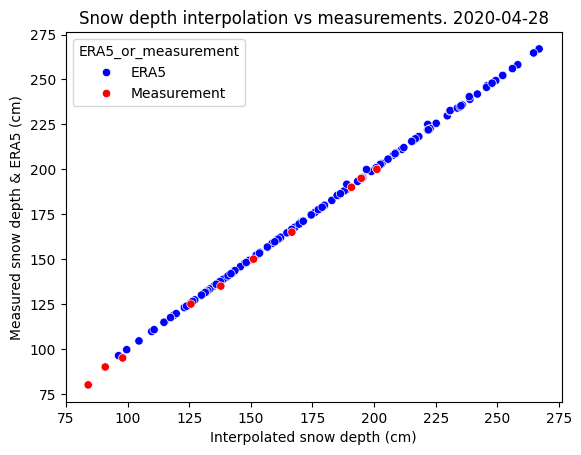

In [100]:
list_of_tuples = list(zip(sd_interpolated_list, sd_measurments_and_era5list, era5_or_measurement))

 
# Converting lists of tuples into
# pandas Dataframe.
df_interpolation = pd.DataFrame(list_of_tuples,
                  columns=['SD_interpolation', 'Inpunt_SD', 'ERA5_or_measurement'])
 
# Print data.
print(df_interpolation)
import seaborn as sns
color_map = {"ERA5": "blue", "Measurement": "red"}

sns_plot  = sns.scatterplot(x="SD_interpolation", y="Inpunt_SD", data=df_interpolation, hue="ERA5_or_measurement", palette=color_map);
plt.title(f"Snow depth interpolation vs measurements. {chosen_time}")
plt.xlabel("Interpolated snow depth (cm)")
plt.ylabel("Measured snow depth & ERA5 (cm)")


In [54]:
print(df_interpolation.to_markdown())

|     |   SD_interpolation |   Inpunt_SD | ERA5_or_measurement   |
|----:|-------------------:|------------:|:----------------------|
|   0 |           222.272  |    222.272  | ERA5                  |
|   1 |           213.321  |    215.469  | ERA5                  |
|   2 |           206.967  |    208.063  | ERA5                  |
|   3 |           200.653  |    202.575  | ERA5                  |
|   4 |           193.503  |    193.708  | ERA5                  |
|   5 |           186.83   |    187.201  | ERA5                  |
|   6 |           179.682  |    181.791  | ERA5                  |
|   7 |           170.849  |    173.626  | ERA5                  |
|   8 |           161.629  |    166.802  | ERA5                  |
|   9 |           153.822  |    157.168  | ERA5                  |
|  10 |           147.55   |    148.592  | ERA5                  |
|  11 |           140.658  |    140.32   | ERA5                  |
|  12 |           132.53   |    130.866  | ERA5               

In [ ]:
#save data
folder_path_1 = r"Scripts\Python\ERA5\ERA5_interp_data"
folder_name = "Interpolation_" + chosen_time
folder_path = os.path.join(folder_path_1, folder_name)
#create a folder with folder path
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plot_contour = 'contour_plot_' + chosen_time + '.png'
plot_corr = 'correlation_plot_' + chosen_time + '.png'
contour_folder_path = os.path.join(folder_path, plot_contour)
corr_folder_path = os.path.join(folder_path, plot_corr)
#save the plot
contour.figure.savefig(contour_folder_path)
sns_plot.figure.savefig(corr_folder_path)

#export csv df_interpolation
csv_name = 'interpolation_data_' + chosen_time + '.csv'
csv_path = os.path.join(folder_path, csv_name)
df_interpolation.to_csv(csv_path, index=False)

# Annað interpolation, ekkert spes

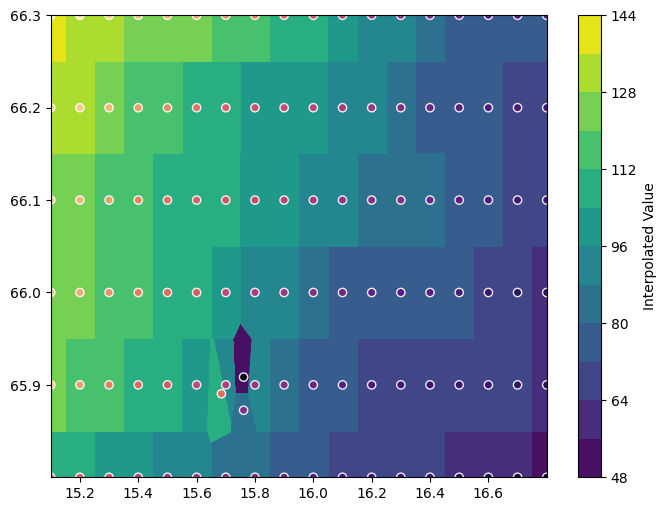

In [168]:
import geopandas as gpd
from scipy.interpolate import RegularGridInterpolator
import numpy as np
from scipy.interpolate import griddata

# Read the shapefile
gdf = gpd.read_file(complete_path_output_pluspoints)

# Assume your shapefile has a column named 'value' that contains the values you want to interpolate
# If not, replace 'value' with the name of your column containing the values
values = gdf['snow_depth']

# Extract coordinates
coordinates = np.column_stack((gdf.geometry.x, gdf.geometry.y))

# Define grid points for interpolation
x = np.linspace(coordinates[:, 0].min(), coordinates[:, 0].max(), 1000)
y = np.linspace(coordinates[:, 1].min(), coordinates[:, 1].max(), 1000)
X, Y = np.meshgrid(x, y)

# Interpolate values
Z = griddata(coordinates, values, (X, Y), method='nearest')

# Stack interpolated coordinates and values
interpolated_points = np.column_stack((X.flatten(), Y.flatten(), Z.flatten()))


# Reshape interpolated points to match the grid
Z = Z.reshape(X.shape)

# Plot interpolated data
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, cmap='viridis',levels=10)  # Contour plot
plt.colorbar(label='Interpolated Value')
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=values, cmap='magma', alpha=0.9, edgecolors='w')  # Scatter plot of original data



# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Interpolated Data')
# # plt.grid(True)
# plt.show()
#give points in scatter plot cirlce edge color
# plt.scatter(coordinates[:, 0], coordinates[:, 1], c=values, cmap='viridis', alpha=0.9, edgecolors='k')  # Scatter plot of original data
